Generating scale-space (iterative filtering)...


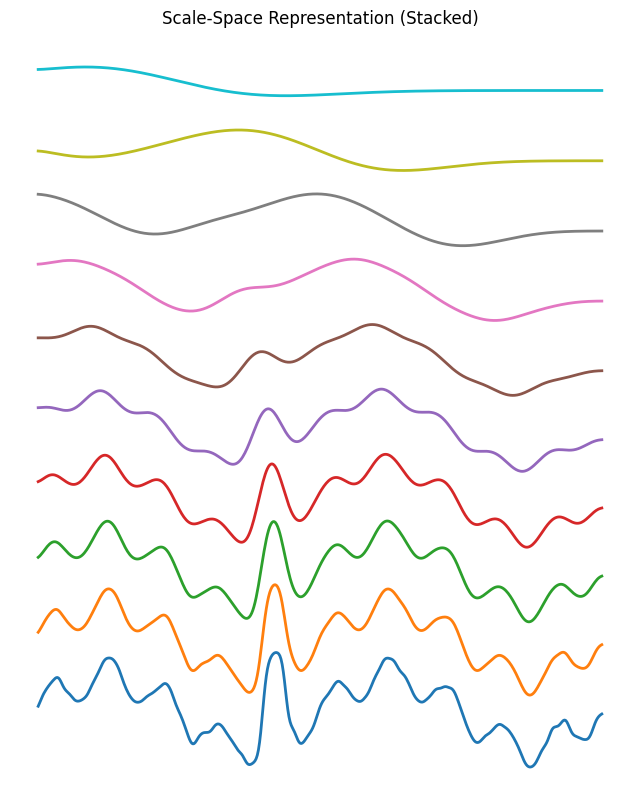

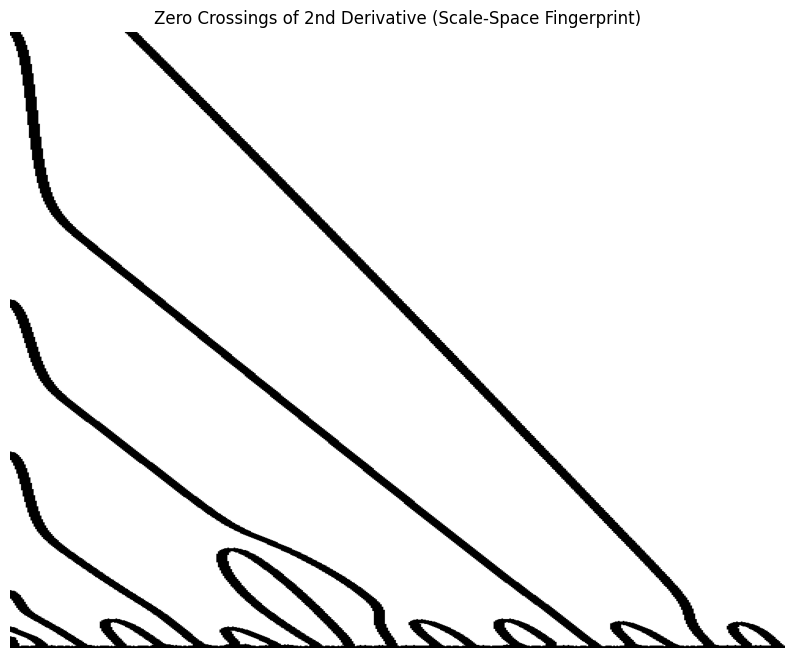

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy import signal
import cv2

def generate_dummy_signal(length=500):
    t = np.linspace(0, 4*np.pi, length)
    wave = np.sin(t) + 0.5 * np.sin(5*t) + 0.2 * np.random.randn(length)
    wave[200:220] += 2.0
    return wave

wave = generate_dummy_signal()
wave = wave - np.mean(wave)

sigma = 3
filter_size = 50
x = np.linspace(-(filter_size // 2), filter_size // 2, filter_size)
gaussian_filter = np.exp(-x**2 / (2 * sigma**2))
gaussian_filter /= np.sum(gaussian_filter)

plt.figure(figsize=(6, 4))
plt.plot(gaussian_filter)
plt.title('Gaussian Filter')
plt.grid(True)
plt.show()

print("Generating scale-space (iterative filtering)...")
number = 1000
smoothed_wave = np.zeros((number + 1, len(wave)))
smoothed_wave[0, :] = wave

for i in range(number):
    smoothed_wave[i + 1, :] = convolve(smoothed_wave[i, :], gaussian_filter, mode='nearest')
s_vec = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

plt.figure(figsize=(8, 10))
plt.title('Scale-Space Representation (Stacked)')
x_axis = np.arange(len(wave))

for n, scale_idx in enumerate(s_vec):
    plt.plot(x_axis, smoothed_wave[scale_idx, :] + n * 2, linewidth=2, label=f'Iter {scale_idx}')

plt.axis('off')
plt.show()

smoothed_subset = smoothed_wave[0:number, :]

zeros_col = np.zeros((smoothed_subset.shape[0], 1))

shifted_1 = np.hstack([zeros_col, smoothed_subset[:, :-1]])
dif1 = smoothed_subset - shifted_1

shifted_2 = np.hstack([zeros_col, dif1[:, :-1]])
dif2 = dif1 - shifted_2


dif2_shifted_left = np.hstack([dif2[:, 1:], dif2[:, 0:1]])
product = dif2 * dif2_shifted_left

margin = 4
bw = product[:, margin : -margin]

bw_binary = (bw < 0).astype(np.float32)

bw_binary = np.flipud(bw_binary)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
bw_dilated = cv2.dilate(bw_binary, kernel, iterations=1)

bw_final = 1 - bw_dilated



plt.figure(figsize=(10, 8))
plt.imshow(bw_final, cmap='gray', aspect='auto')
plt.title('Zero Crossings of 2nd Derivative (Scale-Space Fingerprint)')
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import os

def create_gaussian_kernel(sigma):
    """Membuat kernel Gaussian 2D."""
    w = int(20 * sigma) + 1
    k1d = cv2.getGaussianKernel(w, sigma)
    kernel = np.outer(k1d, k1d)
    return kernel / np.sum(kernel)

def run_heat_diffusion():
    filename = 'bike.png'
    
    if not os.path.exists(filename):
        print(f"File {filename} tidak ditemukan. Membuat dummy...")
        img = np.zeros((300, 300), dtype=np.float64)
        cv2.circle(img, (150, 150), 50, 1.0, -1)
        cv2.rectangle(img, (50, 50), (100, 250), 0.5, -1)
    else:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float64) / 255.0

    sigma = 1
    g = create_gaussian_kernel(sigma)
    fps = 15
    save_movie = True
    iterations = 500
    img_filt = img.copy()

    fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    
    im_obj = ax.imshow(img_filt, cmap='hot', vmin=0, vmax=1)
    ax.axis('off')
    
    cbar = fig.colorbar(im_obj, ax=ax, ticks=[0, 1])
    cbar.ax.set_yticklabels(['Cold', 'Hot'], fontsize=12, color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.outline.set_edgecolor('white')

    text_x = img.shape[1] * 0.8
    text_obj = ax.text(text_x, -10, '', color='white', fontsize=12, ha='center')
    
    video_writer = None
    output_file = 'Heat_Diffusion.avi'
    
    print("Memulai simulasi difusi panas...")
    
    for t in range(1, iterations + 1):
        if t % 50 == 0:
            print(f"Iterasi: {t}/{iterations}")
            
        im_obj.set_data(img_filt)
        text_obj.set_text(f't = {t/fps:.2f} sec')
        
        fig.canvas.draw()
        
        if save_movie:
            buf = fig.canvas.buffer_rgba()

            frame_rgba = np.asarray(buf)
            
            if video_writer is None:
                h, w, _ = frame_rgba.shape
                fourcc = cv2.VideoWriter_fourcc(*'MJPG')
                video_writer = cv2.VideoWriter(output_file, fourcc, fps, (w, h))
            
            frame_bgr = cv2.cvtColor(frame_rgba, cv2.COLOR_RGBA2BGR)
            video_writer.write(frame_bgr)
            
        img_filt = cv2.filter2D(img_filt, -1, g, borderType=cv2.BORDER_REPLICATE)

    if video_writer:
        video_writer.release()
        print(f"Video disimpan sebagai {output_file}")
    
    plt.close()

if __name__ == "__main__":
    run_heat_diffusion()

Memulai simulasi difusi panas...
Iterasi: 50/500
Iterasi: 100/500
Iterasi: 150/500
Iterasi: 200/500
Iterasi: 250/500
Iterasi: 300/500
Iterasi: 350/500
Iterasi: 400/500
Iterasi: 450/500
Iterasi: 500/500
Video disimpan sebagai Heat_Diffusion.avi


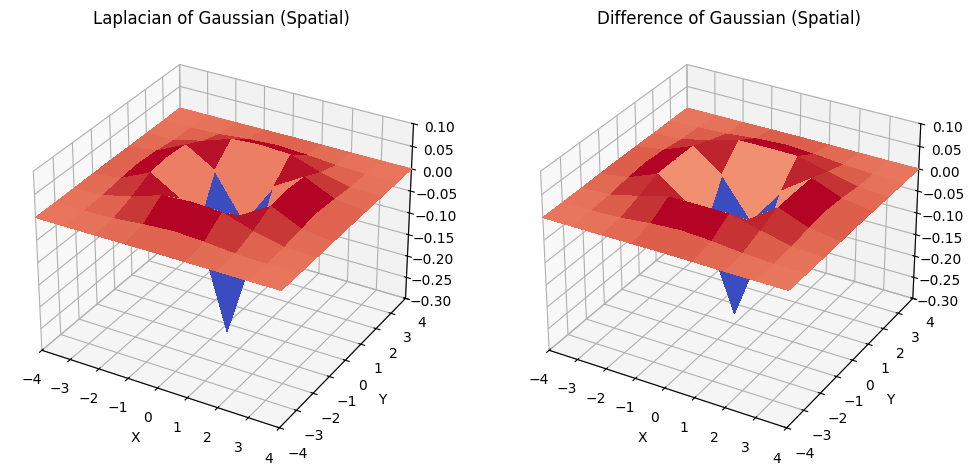

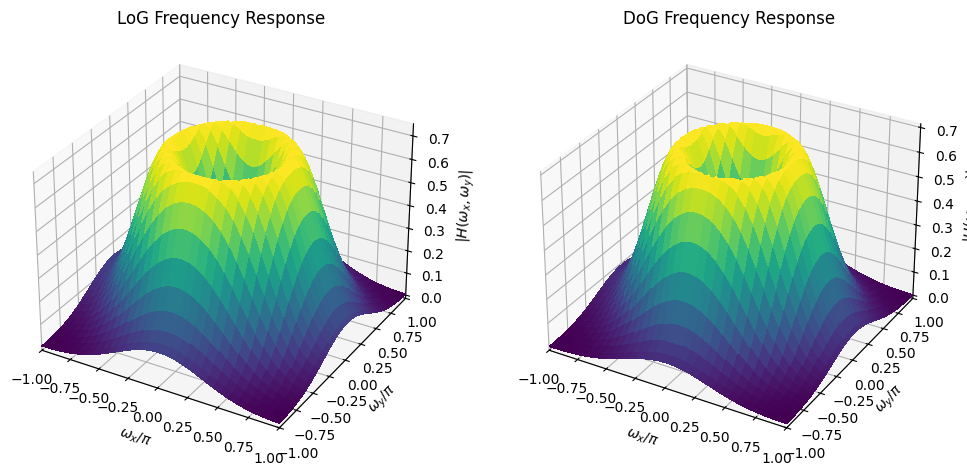

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

x = np.arange(-4, 5, 1)
y = x.copy()
X, Y = np.meshgrid(x, y)

sigma = 1.0
k = 1.1
r2 = X**2 + Y**2

term1 = -1 / (np.pi * sigma**4)
term2 = 1 - r2 / (2 * sigma**2)
term3 = np.exp(-r2 / (2 * sigma**2))
Z1 = term1 * term2 * term3

sigma_k = k * sigma
G1 = (1 / (2 * np.pi * sigma_k**2)) * np.exp(-r2 / (2 * sigma_k**2))

G2 = (1 / (2 * np.pi * sigma**2)) * np.exp(-r2 / (2 * sigma**2))

scale = 1 / ((k - 1) * sigma**2)
Z2 = scale * (G1 - G2)

fig1 = plt.figure(figsize=(12, 6))

ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_title('Laplacian of Gaussian (Spatial)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlim([-0.3, 0.1])
ax1.set_xlim([-4, 4])
ax1.set_ylim([-4, 4])

ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, Z2, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_title('Difference of Gaussian (Spatial)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlim([-0.3, 0.1])
ax2.set_xlim([-4, 4])
ax2.set_ylim([-4, 4])

plt.show()

N = 64
H1 = np.fft.fftshift(np.fft.fft2(Z1, s=(N, N)))
H2 = np.fft.fftshift(np.fft.fft2(Z2, s=(N, N)))

wx = np.linspace(-1, 1, N)
wy = np.linspace(-1, 1, N)
WX, WY = np.meshgrid(wx, wy)

fig2 = plt.figure(figsize=(12, 6))

ax3 = fig2.add_subplot(1, 2, 1, projection='3d')
ax3.plot_surface(WX, WY, np.abs(H1), cmap=cm.viridis, linewidth=0, antialiased=False)
ax3.set_title('LoG Frequency Response')
ax3.set_xlabel(r'$\omega_x / \pi$')
ax3.set_ylabel(r'$\omega_y / \pi$')
ax3.set_zlabel(r'$| H(\omega_x, \omega_y) |$')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])

ax4 = fig2.add_subplot(1, 2, 2, projection='3d')
ax4.plot_surface(WX, WY, np.abs(H2), cmap=cm.viridis, linewidth=0, antialiased=False)
ax4.set_title('DoG Frequency Response')
ax4.set_xlabel(r'$\omega_x / \pi$')
ax4.set_ylabel(r'$\omega_y / \pi$')
ax4.set_zlabel(r'$| H(\omega_x, \omega_y) |$')
ax4.set_xlim([-1, 1])
ax4.set_ylim([-1, 1])

plt.show()

Processed t=1, Kernel Size=7x7
Processed t=4, Kernel Size=13x13
Processed t=16, Kernel Size=25x25
Processed t=64, Kernel Size=49x49


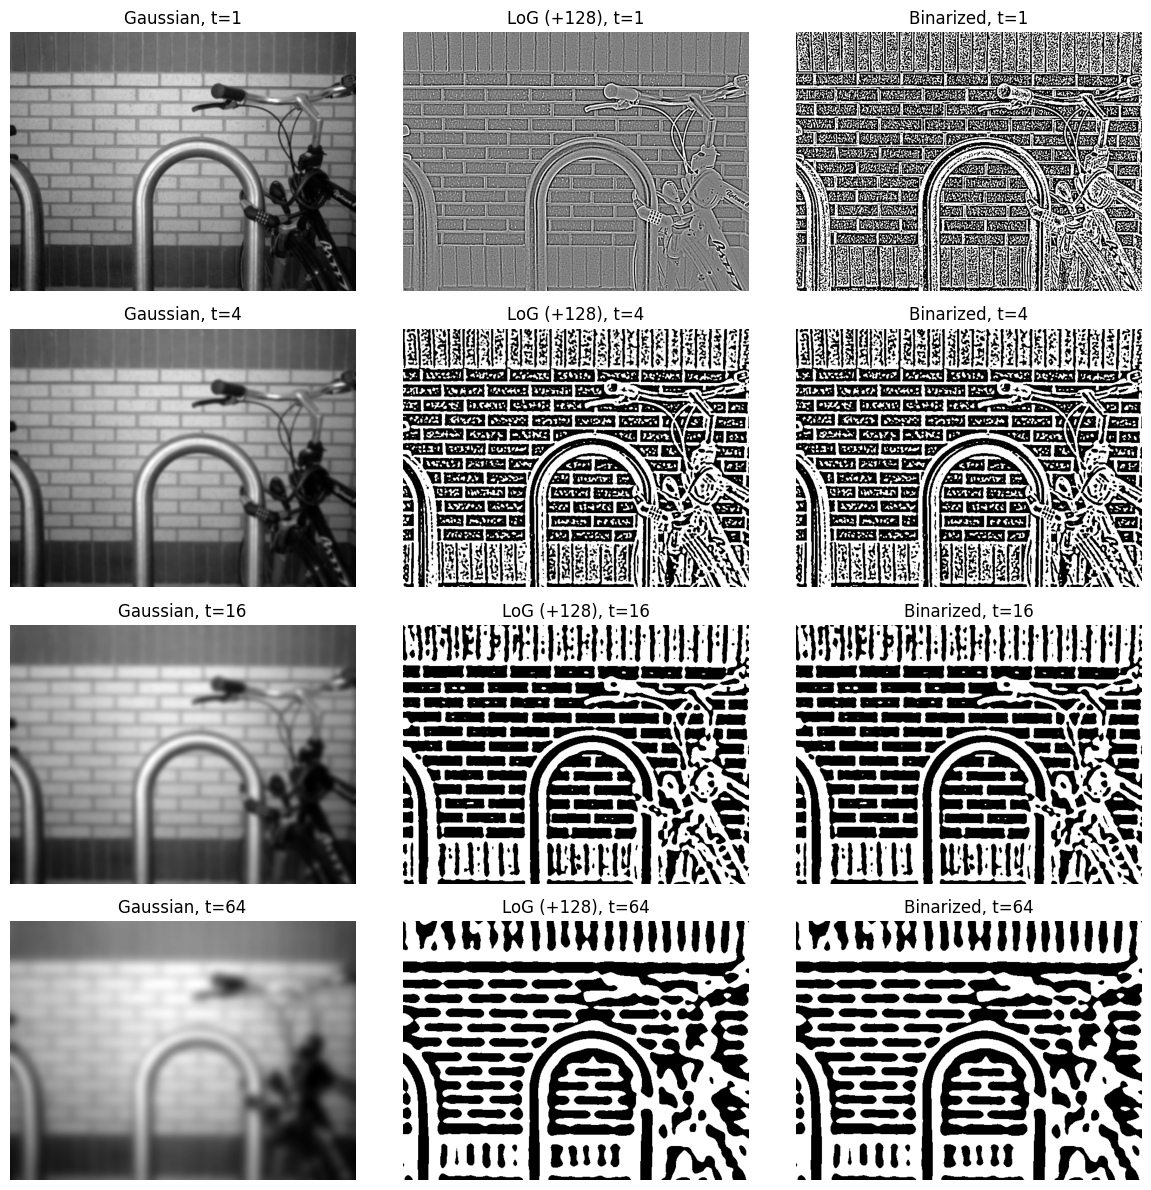

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def create_gaussian_kernel(size, sigma):

    if size % 2 == 0: size += 1
    
    k1d = cv2.getGaussianKernel(size, sigma)
    kernel = np.outer(k1d, k1d)
    return kernel

def create_log_kernel(size, sigma):
    if size % 2 == 0: size += 1
    k = (size - 1) // 2
    x = np.arange(-k, k + 1)
    y = np.arange(-k, k + 1)
    xx, yy = np.meshgrid(x, y)
    
    
    r2 = xx**2 + yy**2
    h = (r2 - 2*sigma**2) * np.exp(-r2 / (2*sigma**2))
    
    h = h - h.mean()
    
    return h

def run_scale_space():
    filename = 'bike.png'
    
    if not os.path.exists(filename):
        print("File tidak ditemukan, membuat dummy image...")
        img = np.zeros((300, 300), dtype=np.uint8)
        cv2.circle(img, (100, 100), 10, 255, -1)
        cv2.circle(img, (200, 200), 40, 255, -1)
        cv2.rectangle(img, (50, 200), (100, 250), 128, -1)
    else:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img_float = img.astype(np.float64)

    t_array = [1, 4, 16, 64]
    
    plt.figure(figsize=(12, 12))

    for i, t in enumerate(t_array):
        sigma = np.sqrt(t)
        f_size = int(np.ceil(sigma * 3) * 2 + 1)
        h1 = create_gaussian_kernel(f_size, sigma)
        h2 = create_log_kernel(f_size, sigma)
        
        filtered_img1 = cv2.filter2D(img_float, -1, h1, borderType=cv2.BORDER_REPLICATE)
        filtered_img1_uint = np.clip(filtered_img1, 0, 255).astype(np.uint8)
        
        filtered_img2 = cv2.filter2D(img_float, -1, h2, borderType=cv2.BORDER_REPLICATE)
        filtered_img2 = t * filtered_img2
        
        bw = (filtered_img2 >= 0).astype(np.uint8) * 255
        
        filtered_img2_disp = np.clip(filtered_img2 + 128, 0, 255).astype(np.uint8)
        
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(filtered_img1_uint, cmap='gray')
        plt.title(f'Gaussian, t={t}')
        plt.axis('off')
        
        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(filtered_img2_disp, cmap='gray')
        plt.title(f'LoG (+128), t={t}')
        plt.axis('off')
        
        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(bw, cmap='gray')
        plt.title(f'Binarized, t={t}')
        plt.axis('off')

        cv2.imwrite(f'Laplacian_gau_{t}.png', filtered_img1_uint)
        cv2.imwrite(f'Laplacian_log_{t}.png', filtered_img2_disp)
        cv2.imwrite(f'Laplacian_bw_{t}.png', bw)
        
        print(f"Processed t={t}, Kernel Size={f_size}x{f_size}")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_scale_space()

Processing t = 1, sigma = 1.0, thresh = 9


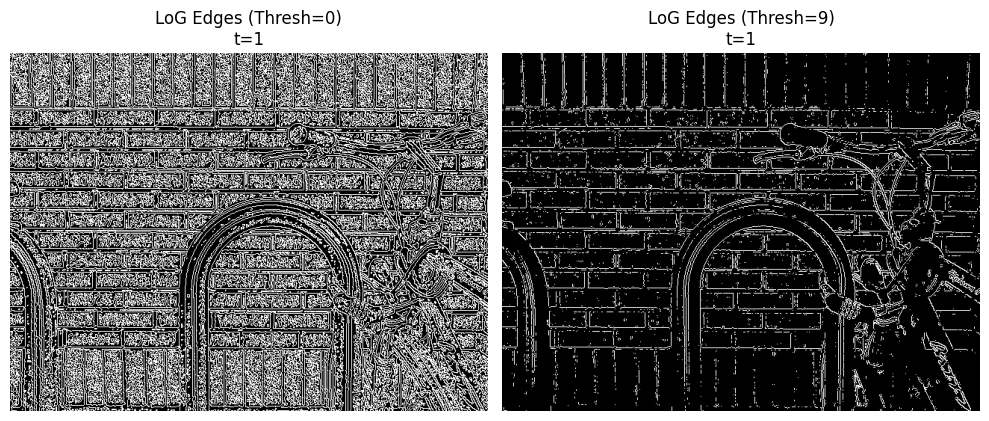

Processing t = 4, sigma = 2.0, thresh = 1


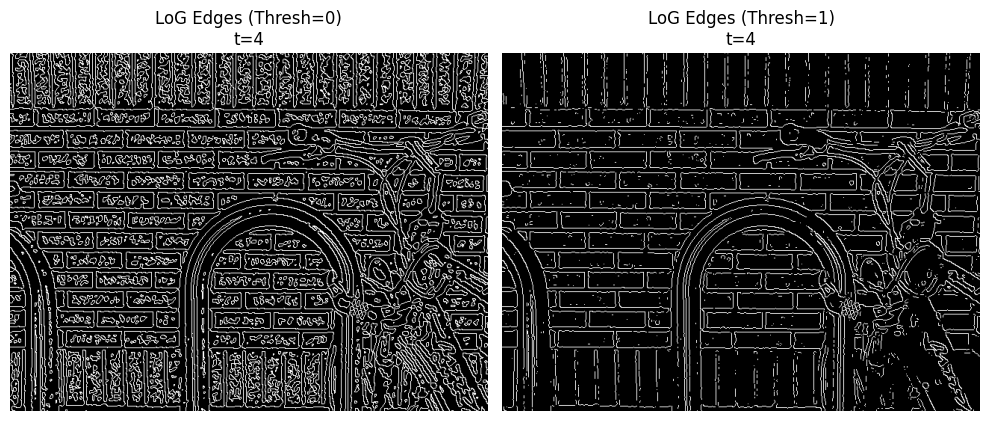

Processing t = 16, sigma = 4.0, thresh = 0.05


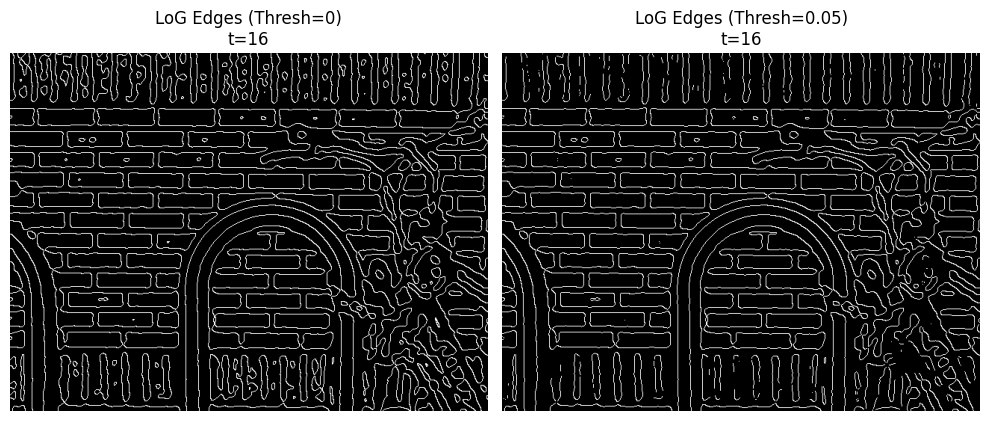

Processing t = 64, sigma = 8.0, thresh = 0.005


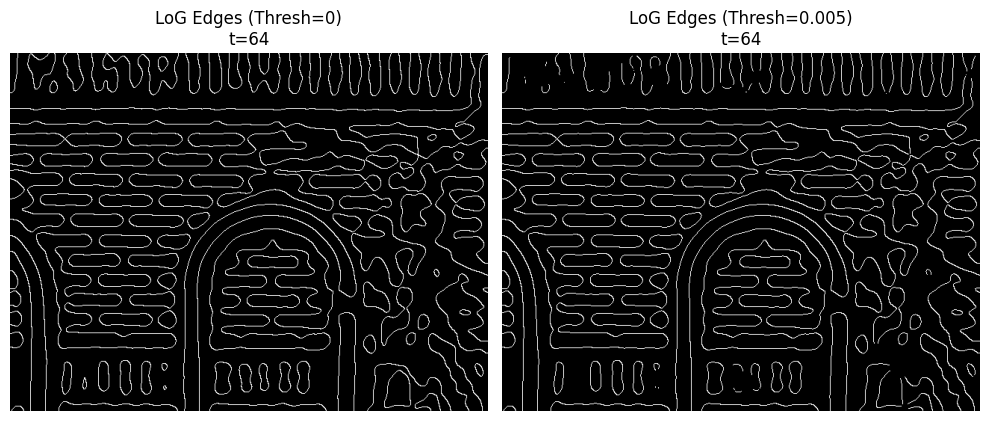

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace
import os

def find_zero_crossings(log_img, threshold=0):

    diff_h = (log_img[:, :-1] * log_img[:, 1:]) < 0
    mag_h = np.abs(log_img[:, :-1] - log_img[:, 1:]) > threshold
    edge_h = diff_h & mag_h
    
    diff_v = (log_img[:-1, :] * log_img[1:, :]) < 0
    mag_v = np.abs(log_img[:-1, :] - log_img[1:, :]) > threshold
    edge_v = diff_v & mag_v
    
    edges = np.zeros_like(log_img, dtype=bool)
    
    edges[:, 1:][edge_h] = True
    edges[1:, :][edge_v] = True
    
    return edges

def run_scale_space_edges():
    filename = 'bike.png'

    if os.path.exists(filename):
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float64)
    else:
        print(f"File {filename} tidak ditemukan. Menggunakan dummy image.")
        img = np.zeros((300, 300), dtype=np.float64)
        cv2.circle(img, (150, 150), 50, 200, -1)
        cv2.rectangle(img, (50, 50), (100, 250), 100, -1)

    t_array = [1, 4, 16, 64]
    thresh_array = [9, 1, 0.05, 0.005]

    for i in range(len(t_array)):
        t = t_array[i]
        sigma = np.sqrt(t)
        current_thresh = thresh_array[i]
        
        print(f"Processing t = {t}, sigma = {sigma:.1f}, thresh = {current_thresh}")
        

        log_response = gaussian_laplace(img, sigma=sigma)
        

        img_edge1 = find_zero_crossings(log_response, threshold=0)
        

        img_edge2 = find_zero_crossings(log_response, threshold=current_thresh)
        

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_edge1, cmap='gray')
        plt.title(f'LoG Edges (Thresh=0)\nt={t}')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(img_edge2, cmap='gray')
        plt.title(f'LoG Edges (Thresh={current_thresh})\nt={t}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        save_1 = (img_edge1 * 255).astype(np.uint8)
        save_2 = (img_edge2 * 255).astype(np.uint8)
        
        cv2.imwrite(f'Laplacian_edge1_{t}.png', save_1)
        cv2.imwrite(f'Laplacian_edge2_{t}.png', save_2)

if __name__ == "__main__":
    run_scale_space_edges()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace
import os

def detect_zero_crossings(log_response):

    diff_h = (log_response[:, :-1] * log_response[:, 1:]) < 0
    
    diff_v = (log_response[:-1, :] * log_response[1:, :]) < 0
    
    edges = np.zeros_like(log_response, dtype=bool)
    
    edges[:, 1:][diff_h] = True
    edges[1:, :][diff_v] = True
    
    return edges

def run_scale_space_animation():

    filename = 'bike.png'
    

    if not os.path.exists(filename):
        print(f"File {filename} tidak ditemukan. Membuat dummy...")
        img = np.zeros((300, 300), dtype=np.float64)
        cv2.circle(img, (150, 150), 60, 1.0, -1)
        cv2.rectangle(img, (50, 50), (100, 250), 0.5, -1)
    else:

        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float64) / 255.0


    fps = 15
    iterations = 500
    output_file = 'chap8_zero-cross.avi'

    fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    initial_edges = np.zeros_like(img)
    im_obj = ax.imshow(initial_edges, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    text_obj = ax.text(img.shape[1] * 0.8, -10, '', color='white', fontsize=15, ha='center')
    
    video_writer = None
    
    print("Generating Scale-Space Animation...")
    
    for t in range(1, iterations + 1):
        if t % 50 == 0:
            print(f"Frame: {t}/{iterations}")
            
        sigma = np.sqrt(0.1 * t)
        
        log_response = gaussian_laplace(img, sigma=sigma)
        
        edges = detect_zero_crossings(log_response)
        
        im_obj.set_data(edges)
        text_obj.set_text(f't = {t/fps:.2f} sec')
        
        fig.canvas.draw()
        

        buf = fig.canvas.buffer_rgba()
        frame_rgba = np.asarray(buf)
        
        if video_writer is None:
            h, w, _ = frame_rgba.shape
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            video_writer = cv2.VideoWriter(output_file, fourcc, fps, (w, h))
        
        frame_bgr = cv2.cvtColor(frame_rgba, cv2.COLOR_RGBA2BGR)
        video_writer.write(frame_bgr)

    if video_writer:
        video_writer.release()
        print(f"Video disimpan: {output_file}")
    
    plt.close()

if __name__ == "__main__":
    run_scale_space_animation()

Generating Scale-Space Animation...
Frame: 50/500
Frame: 100/500
Frame: 150/500
Frame: 200/500
Frame: 250/500
Frame: 300/500
Frame: 350/500
Frame: 400/500
Frame: 450/500
Frame: 500/500
Video disimpan: chap8_zero-cross.avi


<>:153: SyntaxWarning: invalid escape sequence '\s'
<>:153: SyntaxWarning: invalid escape sequence '\s'
C:\Users\heman\AppData\Local\Temp\ipykernel_7316\4281274095.py:153: SyntaxWarning: invalid escape sequence '\s'
  filename = 'keypointExtraction\sunflower.jpg'


Detecting top 150 blobs using LoG Scale Selection...
Done. Found 150 keypoints.


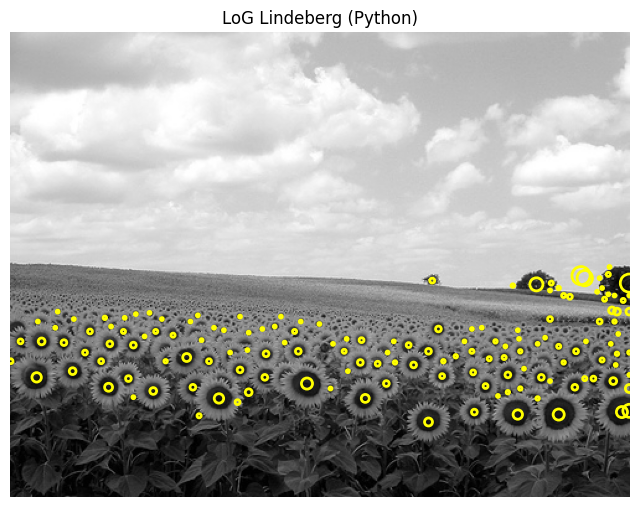

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import gaussian_laplace, maximum_filter
import os

def kp_log(img_gray, num_blobs):

    if img_gray.dtype == np.uint8:
        img = img_gray.astype(np.float64) / 255.0
    else:
        img = img_gray

    h, w = img.shape
    
    sigma_begin = 2.0
    sigma_end = 20.0
    num_intervals = 15
    
    k = (sigma_end / sigma_begin) ** (1.0 / (num_intervals - 1))
    sigmas = np.zeros(num_intervals)
    sigmas[0] = sigma_begin
    for i in range(1, num_intervals):
        sigmas[i] = sigmas[i-1] * k
        
    scale_space = np.zeros((h, w, num_intervals))
    
    for i, sigma in enumerate(sigmas):

        res = gaussian_laplace(img, sigma=sigma)
        
        scale_space[:, :, i] = np.abs(res * (sigma**2))
    size = 3
    local_max = maximum_filter(scale_space, size=(size, size, size))
    
    is_max = (scale_space == local_max)
    
    threshold = 0.001 * np.max(scale_space)
    is_max[scale_space < threshold] = False
    
    rows, cols, s_idxs = np.where(is_max)
    
    blobs = []
    for r, c, s_idx in zip(rows, cols, s_idxs):
        score = scale_space[r, c, s_idx]
        sigma_val = sigmas[s_idx]
        blobs.append([r, c, sigma_val, score])
        
    blobs = np.array(blobs)
    
    if len(blobs) > 0:
        sort_indices = np.argsort(blobs[:, 3])[::-1]

        limit = min(len(blobs), num_blobs)
        top_blobs = blobs[sort_indices[:limit]]
        
        return top_blobs[:, 0:3]
    else:
        return np.empty((0, 3))

def draw(img, pt, str_title):

    fig, ax = plt.subplots(figsize=(8, 8))
    fig.canvas.manager.set_window_title(str_title)
    
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
        
    ax.set_title(str_title)
    ax.axis('off')
    if pt.shape[1] >= 3:
        
        visual_radii = 0.6 * pt[:, 2]
        
        for i in range(len(pt)):
            row, col = pt[i, 0], pt[i, 1]
            radius = visual_radii[i]
            circ = patches.Circle((col, row), radius, 
                                  linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(circ)
            
    elif pt.shape[1] == 2:
        s = 2
        for i in range(len(pt)):
            row, col = pt[i, 0], pt[i, 1]
            rect = patches.Rectangle((col - s, row - s), 2*s, 2*s,
                                     linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)

    plt.show()

if __name__ == "__main__":
    filename = 'keypointExtraction\sunflower.jpg' 
    num_blobs = 150
    
    if not os.path.exists(filename):
        print(f"Error: File '{filename}' tidak ditemukan di folder ini.")
        print("Pastikan Anda sudah menaruh file gambar hasil download di sebelah script ini.")
    else:
        img = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        print(f"Detecting top {num_blobs} blobs using LoG Scale Selection...")
        pt = kp_log(img_gray, num_blobs)
        
        print(f"Done. Found {len(pt)} keypoints.")
        
        draw(img_gray, pt, 'LoG Lindeberg (Python)')

Membangun DoG Pyramid...
Visualisasi...


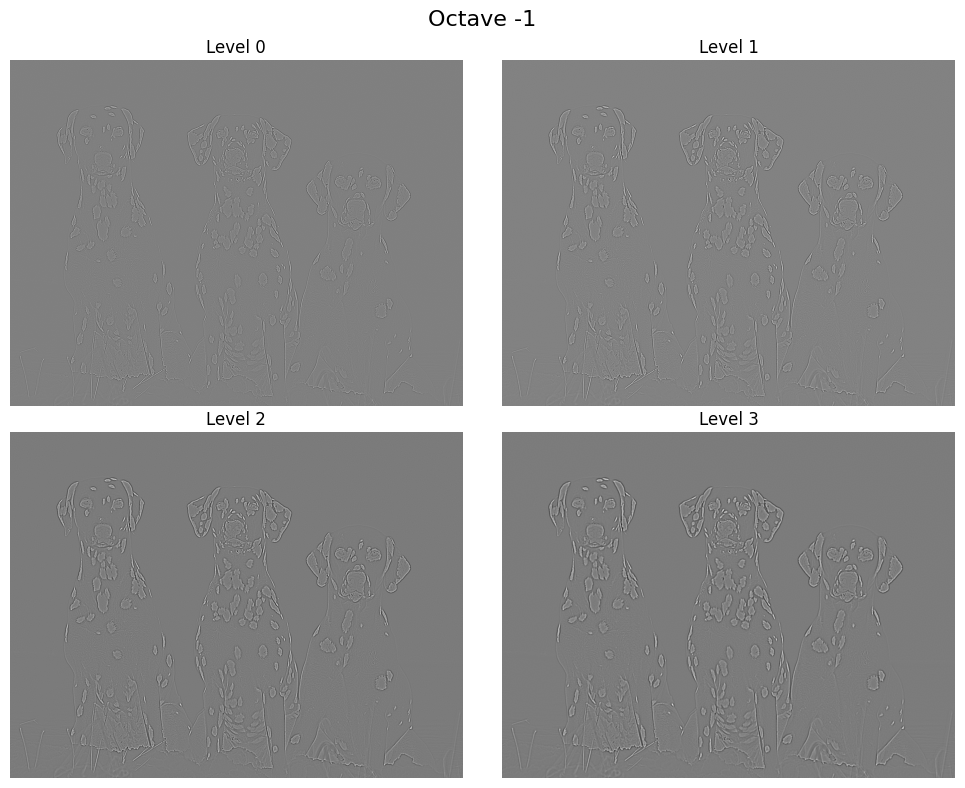

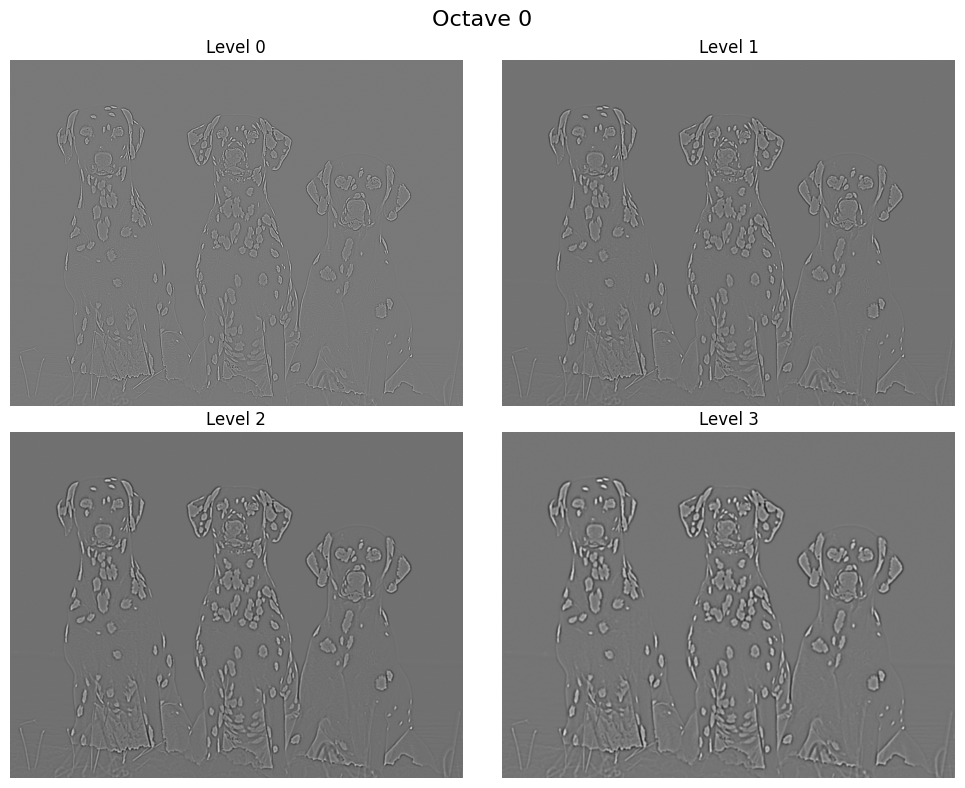

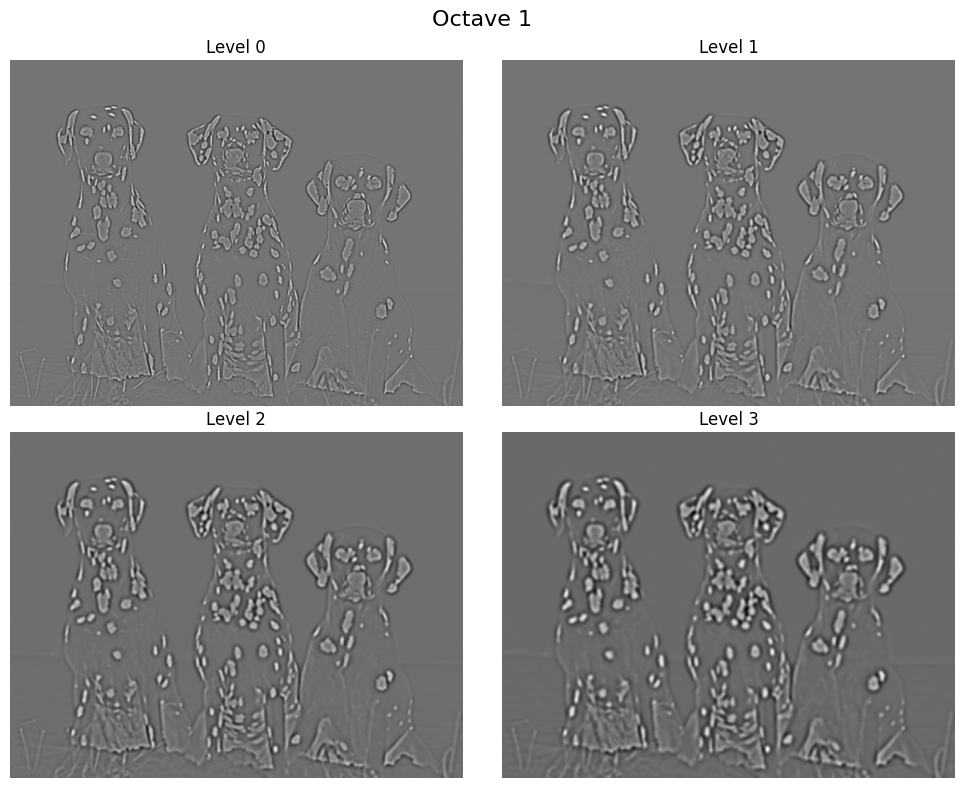

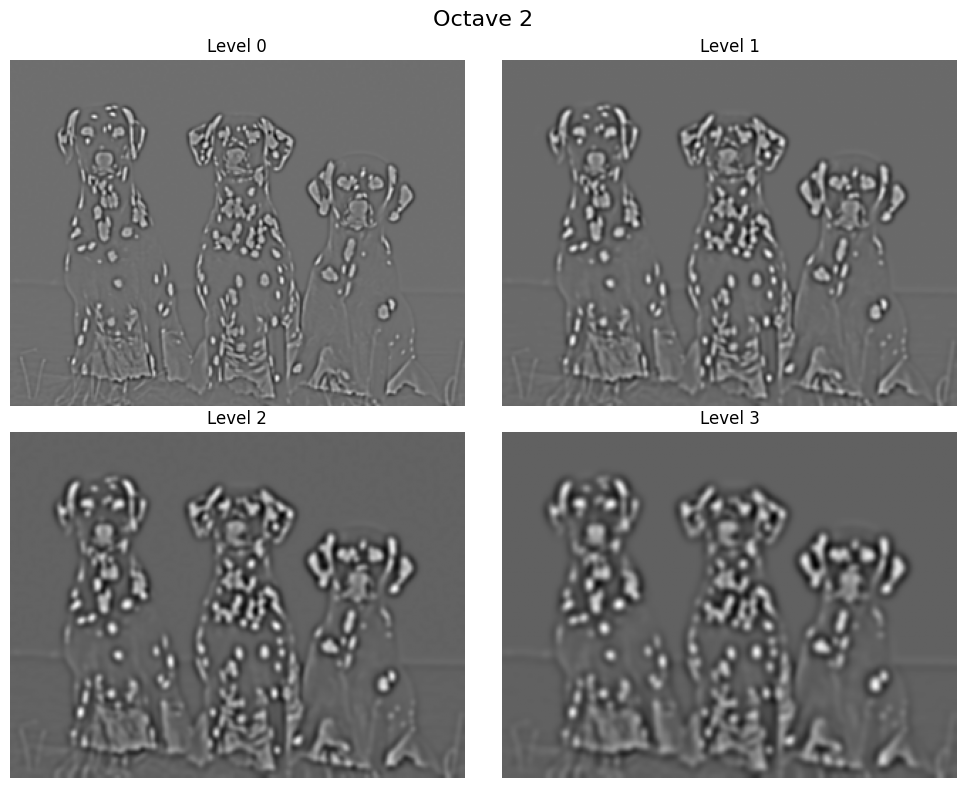

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def build_dog_pyramid(img_gray):

    n_octaves = 4
    n_scales_per_octave = 4
    sigma = 1.6
    k = 2 ** (1.0 / n_scales_per_octave)
    
    pyramid_dog = []
    
    current_img = cv2.resize(img_gray, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    
    sigma_init = np.sqrt(sigma**2 - (0.5 * 2)**2)
    current_img = cv2.GaussianBlur(current_img, (0, 0), sigmaX=sigma_init, sigmaY=sigma_init)
    
    for octave in range(-1, n_octaves - 1):
        gaussian_images = [current_img]
        dog_images_in_octave = []
        
        current_sigma = sigma
        
        for i in range(n_scales_per_octave):
            
            sigma_step = current_sigma * np.sqrt(k**2 - 1)

            blurred = cv2.GaussianBlur(gaussian_images[-1], (0, 0), sigmaX=sigma_step, sigmaY=sigma_step)
            gaussian_images.append(blurred)
            
            current_sigma *= k
            
        for i in range(len(gaussian_images) - 1):
            dog = cv2.subtract(gaussian_images[i+1], gaussian_images[i])
            dog_images_in_octave.append(dog)
            
        pyramid_dog.append(dog_images_in_octave)

        current_img = cv2.resize(base_for_next, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)

    return pyramid_dog

def visualize_dog_pyramid(pyramid):
    for octave_idx, octave_imgs in enumerate(pyramid):
        octave_num = octave_idx - 1 
        

        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        fig.suptitle(f'Octave {octave_num}', fontsize=16)
        axes = axes.flatten()
        
        for level, img in enumerate(octave_imgs):
            if level >= 4: break
            
            disp_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            
            axes[level].imshow(disp_img, cmap='gray')
            axes[level].set_title(f'Level {level}')
            axes[level].axis('off')
            
        plt.tight_layout()
        plt.show()

filename = 'dog.jpg'

if not os.path.exists(filename):
    print("File tidak ditemukan. Membuat gambar dummy...")
    img = np.zeros((512, 512), dtype=np.uint8)
    for i in range(0, 512, 20):
        cv2.line(img, (i, 0), (i, 512), 150, 2)
    for i in range(0, 512, 50):
        cv2.circle(img, (256, 256), i, 200, 3)
else:
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

if img is None:
    img = np.zeros((512, 512), dtype=np.uint8)

img_float = img.astype(np.float32) / 255.0

print("Membangun DoG Pyramid...")
pyramid = build_dog_pyramid(img_float)

print("Visualisasi...")
visualize_dog_pyramid(pyramid)



Processing dog.jpg...
2149 SIFT keypoints detected.


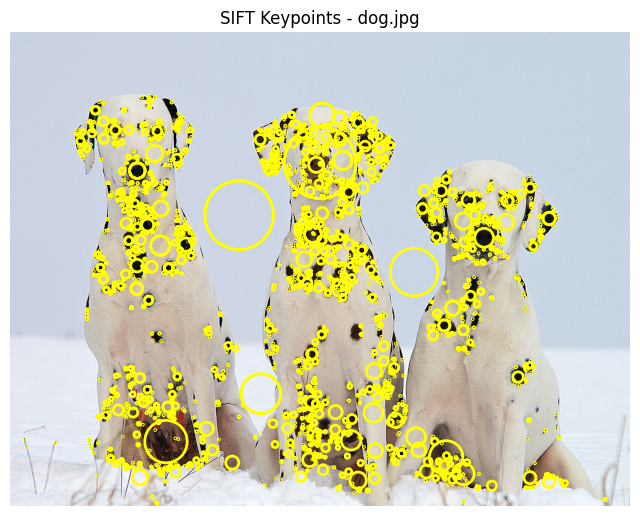

SURF tidak tersedia (Patented/Non-Free). Menggunakan AKAZE sebagai alternatif modern.
200 AKAZE (SURF Fallback) keypoints detected (Selected Strongest).


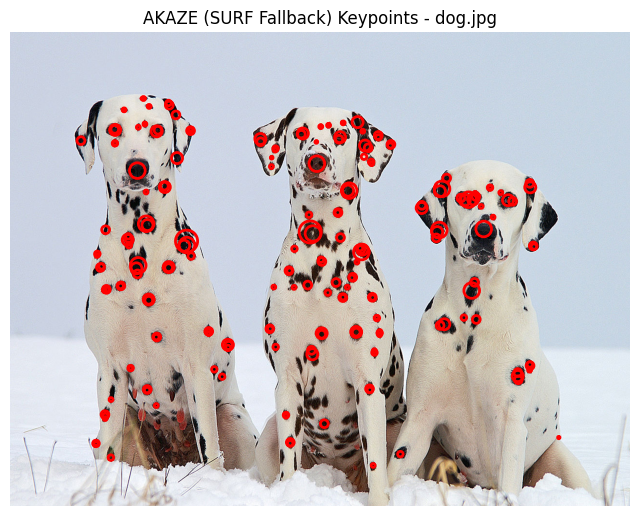


Processing sunflower.jpg...
1278 SIFT keypoints detected.


SURF tidak tersedia (Patented/Non-Free). Menggunakan AKAZE sebagai alternatif modern.
150 AKAZE (SURF Fallback) keypoints detected (Selected Strongest).


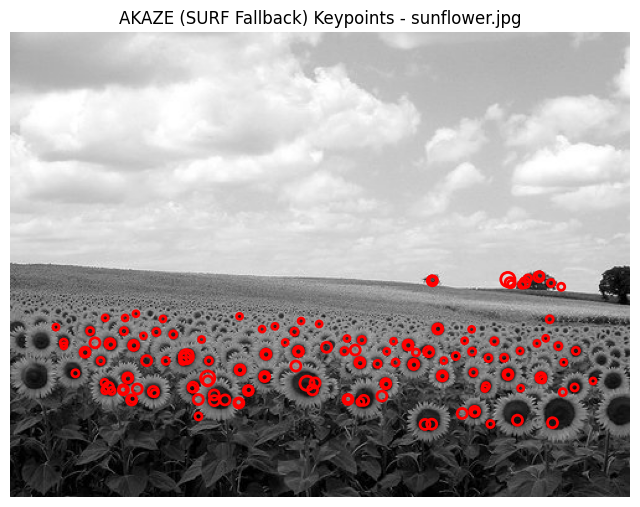

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

def plot_blobs(img, keypoints, title, color='y'):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
    ax.set_title(title)
    ax.axis('off')
    
    for kp in keypoints:
        x, y = kp.pt

        radius = kp.size / 2
        
        circ = patches.Circle((x, y), radius, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(circ)
        
    plt.show()

def run_feature_detection():
    images = ['dog.jpg', 'sunflower.jpg']
    
    surf_num_points = [200, 150]
    
    sift_contrast_thresh = [0.08, 0.04] 
    sift_edge_thresh = [10, 10]

    for fname in images:
        if not os.path.exists(fname):
            print(f"File {fname} tidak ditemukan. Membuat dummy...")
            dummy = np.zeros((400, 400, 3), dtype=np.uint8)
            cv2.circle(dummy, (200, 200), 50, (200, 200, 200), -1)
            for i in range(0, 400, 40):
                cv2.circle(dummy, (i, i), 10, (150, 150, 150), -1)
            cv2.imwrite(fname, dummy)


    for i, filename in enumerate(images):
        print(f"\nProcessing {filename}...")
        
        img = cv2.imread(filename)
        if img is None: continue
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        try:
            sift = cv2.SIFT_create(contrastThreshold=sift_contrast_thresh[i], edgeThreshold=sift_edge_thresh[i])
            
            kp_sift = sift.detect(img_gray, None)
            
            print(f"{len(kp_sift)} SIFT keypoints detected.")
            plot_blobs(img, kp_sift, f'SIFT Keypoints - {filename}', color='yellow')
            
        except AttributeError:
            print("SIFT tidak tersedia di versi OpenCV ini.")

        
        target_num = surf_num_points[i]
        kp_surf = []
        algo_name = "SURF"
        
        try:
            surf = cv2.xfeatures2d.SURF_create(400)
            kp_surf = surf.detect(img_gray, None)
            
        except (AttributeError, cv2.error):
            print("SURF tidak tersedia (Patented/Non-Free). Menggunakan AKAZE sebagai alternatif modern.")
            algo_name = "AKAZE (SURF Fallback)"
            akaze = cv2.AKAZE_create()
            kp_surf = akaze.detect(img_gray, None)

        if len(kp_surf) > 0:
            kp_surf = sorted(kp_surf, key=lambda x: x.response, reverse=True)
            kp_surf = kp_surf[:target_num]

        print(f"{len(kp_surf)} {algo_name} keypoints detected (Selected Strongest).")
        plot_blobs(img, kp_surf, f'{algo_name} Keypoints - {filename}', color='red')

if __name__ == "__main__":
    run_feature_detection()